In [64]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvas
from scipy.spatial import distance

# allow us to re-use the framework from the src directory
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))

In [3]:
import max_ent.examples.grid_9_by_9 as G
from max_ent.gridworld import Directions
%matplotlib notebook
np.random.seed(123)

In [4]:
def create_world(title, blue, green, cs=[], ca=[], cc=[], start=0, goal=8, vmin=-50, vmax=10):
    n_cfg = G.config_world(blue, green, cs, ca, cc, goal)
    n = n_cfg.mdp

    # Generate demonstrations and plot the world
    demo = G.generate_trajectories(n.world, n.reward, n.start, n.terminal)
    vmin = -50
    vmax = 10
    G.plot_world(title, n, n_cfg.state_penalties,
           n_cfg.action_penalties, n_cfg.color_penalties,
           demo, n_cfg.blue, n_cfg.green, vmin=vmin, vmax=vmax)   
    return n, n_cfg, demo

# Nominal world

<IPython.core.display.Javascript object>


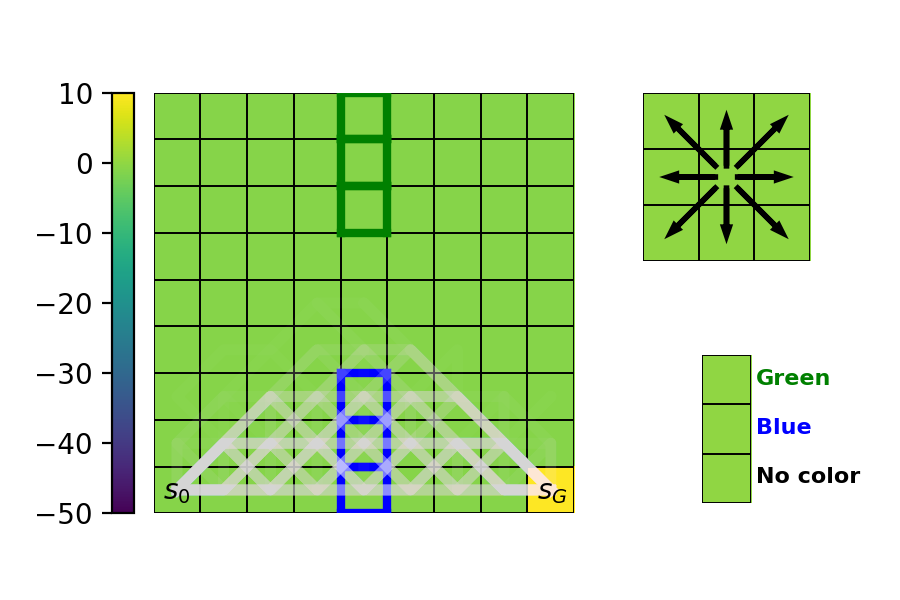

In [5]:
blue = [4, 13, 22]  # blue states
green = [58, 67, 76]  # green states

n, n_cfg, demo_n = create_world('Nominal', blue, green)

## Constrained world

<IPython.core.display.Javascript object>


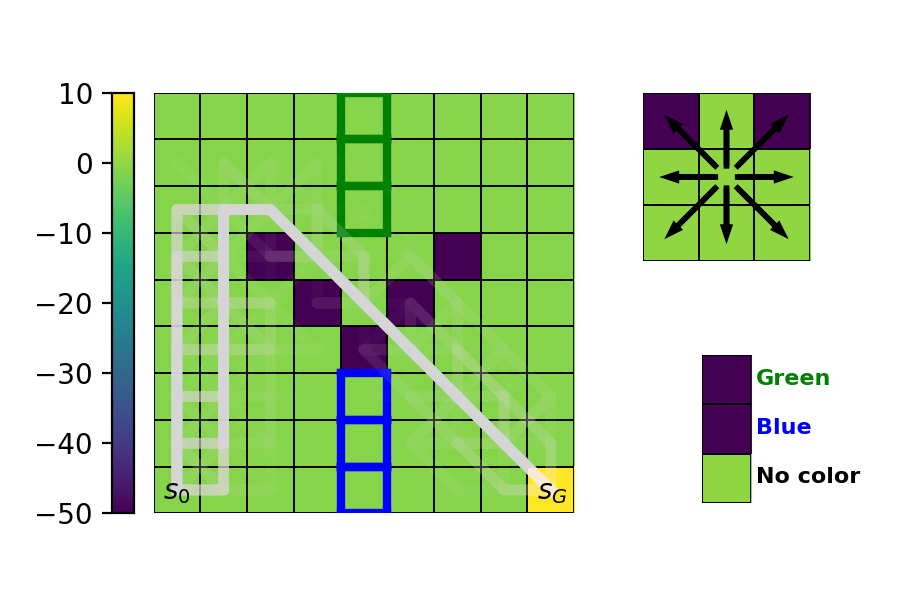

In [7]:
cs = [31, 39, 41, 47, 51]  # constrained states
ca = [Directions.UP_LEFT, Directions.UP_RIGHT]  # constrained actions
cc = [1, 2]  # constrained colors

c, c_cfg, demo_c = create_world('Constrained', blue, green, cs, ca, cc)

## Learn constraints

In [89]:
print(c.reward[2])

[[  -1.   -1.   -1.   -1.  -50.   -1.   -1.   -1.   10.   -1.   -1.   -1.
    -1.  -50.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.  -50.   -1.
    -1.   -1.   -1.   -1.   -1.   -1.   -1.  -50.   -1.   -1.   -1.   -1.
    -1.   -1.   -1.  -50.   -1.  -50.   -1.   -1.   -1.   -1.   -1.  -50.
    -1.   -1.   -1.  -50.   -1.   -1.   -1.   -1.   -1.   -1.  -50.   -1.
    -1.   -1.   -1.   -1.   -1.   -1.   -1.  -50.   -1.   -1.   -1.   -1.
    -1.   -1.   -1.   -1.  -50.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.  -50.   -1.   -1.   -1.   10.   -1.   -1.   -1.
    -1.  -50.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.  -50.   -1.
    -1.   -1.   -1.   -1.   -1.   -1.   -1.  -50.   -1.   -1.   -1.   -1.
    -1.   -1.   -1.  -50.   -1.  -50.   -1.   -1.   -1.   -1.   -1.  -50.
    -1.   -1.   -1.  -50.   -1.   -1.   -1.   -1.   -1.   -1.  -50.   -1.
    -1.   -1.   -1.   -1.   -1.   -1.   -1.  -50.   -1.   -1.   -1.   -1.
    -1.   -1.   -1.   -1.  -50.   -1.   -1.   -1.   -1.

In [12]:
learned_params = G.learn_constraints(n.reward, c.world, c.terminal, demo_c.trajectories)

         1: DELTA:  0.00000, MAE:  0.496315288889989
       101: DELTA:  0.31305, MAE:  0.175528270309275
       201: DELTA:  0.22181, MAE:  0.053586313269923
       301: DELTA:  0.14176, MAE:  0.030193682221069
       401: DELTA:  0.17469, MAE:  0.028076117528057


In [78]:
learned_mdp = G.MDP(c.world, learned_params.reward, c.terminal, c.start)
demo_l = G.generate_trajectories(c.world, learned_params.reward, c.start, c.terminal)

def count_states(trajectories, world):
    count_matrix = np.ones((8,9,9)) * 1e-10
    avg_length = 0.0
    for trajectory in trajectories:
        avg_length += len(trajectory.transitions())
        for state in trajectory.states():
            #print((world.state_index_to_point(state),state))
            count_matrix[0][world.state_index_to_point(state)] += 1
            
    return count_matrix / len(trajectories), avg_length / len(trajectories)

rl_matrix, avg_rl = count_states(demo_l[0], c.world)
print(rl_matrix[0])
print(avg_rl)


# calculate the kl divergence
def kl_divergence(p, q):
    p = np.reshape(p, (-1,1))
    q = np.reshape(q, (-1,1))
    return sum(p[i] * math.log2(p[i]/q[i]) for i in range(len(p)))
    
def js_divergence(p, q):
    p = np.reshape(p, (-1,1))
    q = np.reshape(q, (-1,1))
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)
    
p = G.plot_world('Learned Constrained', learned_mdp, learned_params.state_weights, 
              learned_params.action_weights, learned_params.color_weights, 
              demo_l, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)

[[1.445e+00 9.200e-01 7.650e-01 5.300e-01 4.850e-01 3.900e-01 2.650e-01
  2.000e-02 5.000e-03]
 [4.550e-01 4.900e-01 5.750e-01 6.900e-01 8.050e-01 8.800e-01 1.030e+00
  7.000e-02 5.000e-13]
 [2.500e-02 1.500e-02 2.000e-02 2.500e-02 5.500e-02 4.500e-02 1.040e+00
  4.000e-02 5.000e-13]
 [5.000e-13 5.000e-13 5.000e-13 1.500e-02 1.000e-02 9.550e-01 9.000e-02
  1.000e-02 5.000e-13]
 [5.000e-13 5.000e-13 5.000e-03 1.000e-02 9.050e-01 1.400e-01 2.500e-02
  5.000e-03 5.000e-13]
 [5.000e-13 2.000e-02 3.000e-02 8.600e-01 2.000e-01 3.000e-02 5.000e-13
  5.000e-13 5.000e-13]
 [2.000e-02 5.000e-02 8.750e-01 2.250e-01 2.000e-02 5.000e-03 5.000e-13
  5.000e-13 5.000e-13]
 [5.500e-02 8.850e-01 1.850e-01 2.500e-02 5.000e-03 5.000e-13 5.000e-13
  5.000e-13 5.000e-13]
 [1.000e+00 1.450e-01 2.500e-02 5.000e-03 5.000e-13 5.000e-13 5.000e-13
  5.000e-13 5.000e-13]]
16.92


## MDFT as orchestrator

<IPython.core.display.Javascript object>


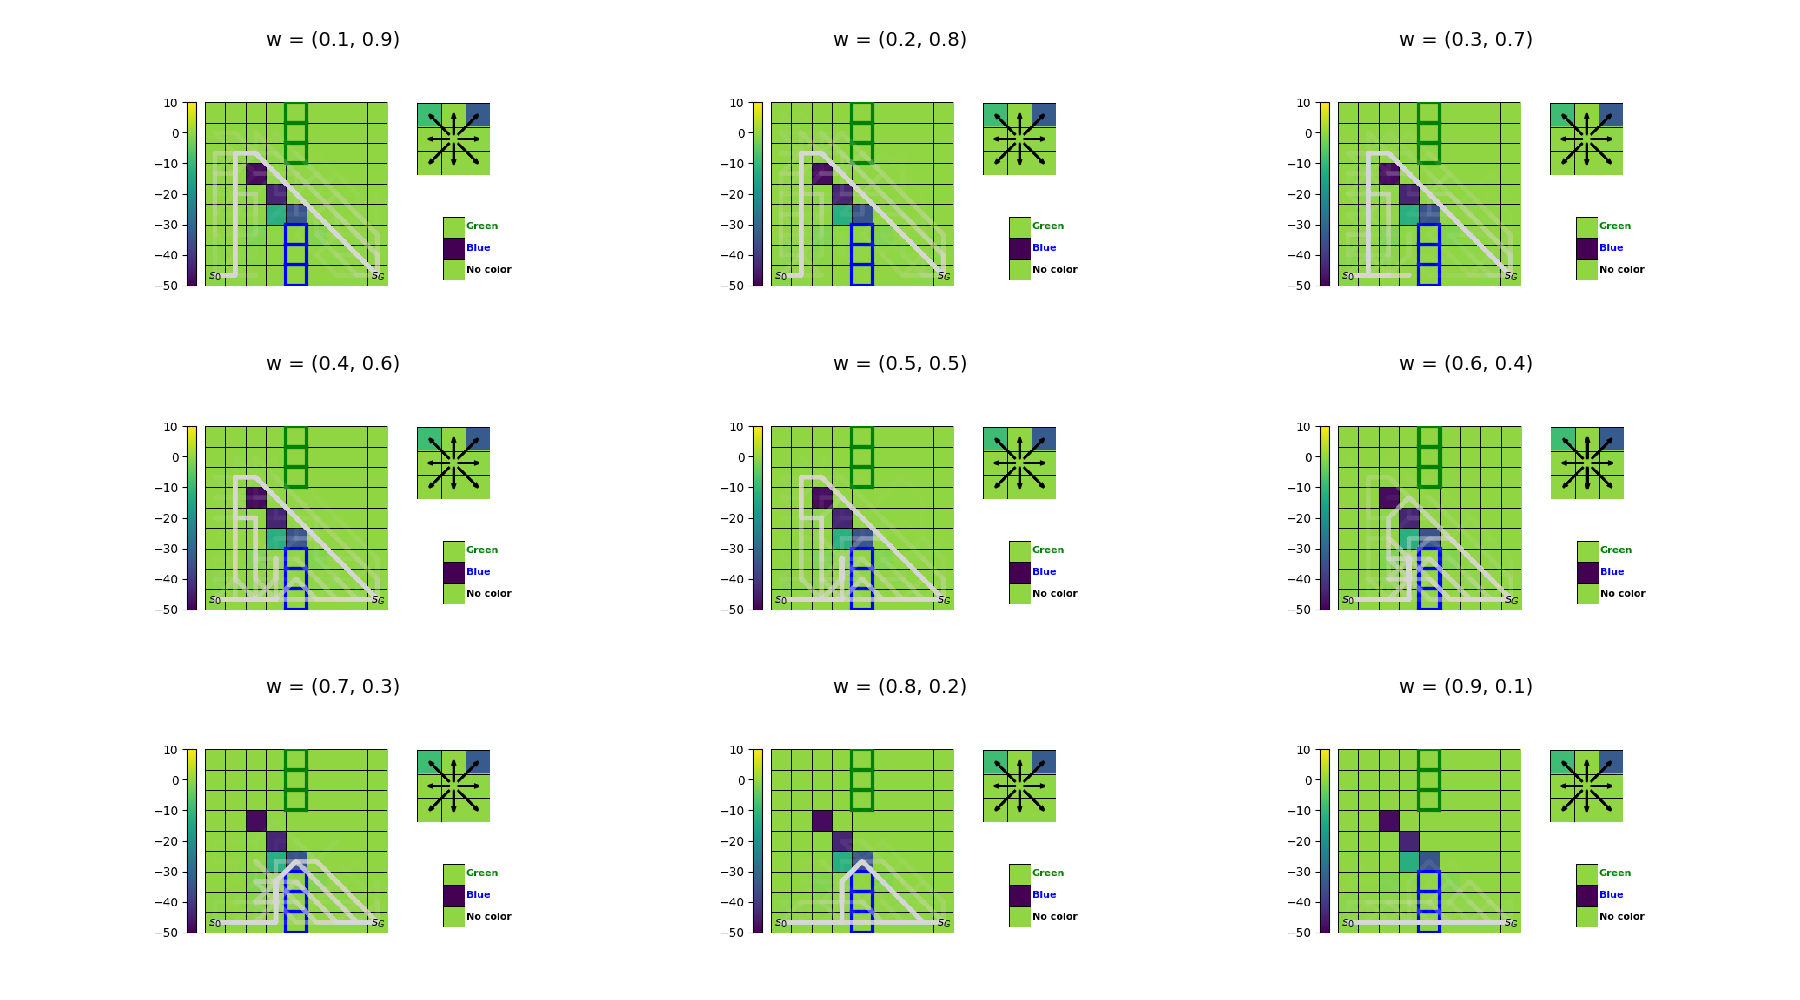

Average Length 16.24
KL(RL||MDFT) [8.36714098] 	 KL(MDFT||RL) [3.96028987]
JS(RL||MDFT) [1.24600436] 	 JS DISTANCE [0.22158823]

Average Length 16.345
KL(RL||MDFT) [9.13054148] 	 KL(MDFT||RL) [12.03770481]
JS(RL||MDFT) [1.49056597] 	 JS DISTANCE [0.24203347]

Average Length 18.43
KL(RL||MDFT) [11.89275975] 	 KL(MDFT||RL) [52.16392648]
JS(RL||MDFT) [2.73984018] 	 JS DISTANCE [0.31794718]

Average Length 34.44
KL(RL||MDFT) [25.97130019] 	 KL(MDFT||RL) [638.50643569]
JS(RL||MDFT) [13.99182366] 	 JS DISTANCE [0.5983922]

Average Length 37.645
KL(RL||MDFT) [35.86832948] 	 KL(MDFT||RL) [828.29950416]
JS(RL||MDFT) [17.6542906] 	 JS DISTANCE [0.6556521]

Average Length 32.69
KL(RL||MDFT) [168.11388188] 	 KL(MDFT||RL) [984.34768562]
JS(RL||MDFT) [18.02734177] 	 JS DISTANCE [0.69541755]

Average Length 26.69
KL(RL||MDFT) [248.47474452] 	 KL(MDFT||RL) [833.01875487]
JS(RL||MDFT) [17.15905891] 	 JS DISTANCE [0.72124303]

Average Length 10.79
KL(RL||MDFT) [341.53948686] 	 KL(MDFT||RL) [174.61610454

In [79]:
fig = plt.figure(figsize=(9, 5))
axis = fig.subplots(3, 3)
for i in range(9):
    w = [(i+1)/10, 1 - (i+1)/10]
    demo_mdft = G.generate_mdft_trajectories(n.world, n.reward, learned_params.reward, n.start, n.terminal, w)
    #print(len(demo_mdft))
    mdft_matrix, avg_mdft = count_states(demo_mdft[0], n.world)
    #print(mdft_matrix[0])
    p = np.reshape(rl_matrix[0], (-1,1))
    q = np.reshape(mdft_matrix[0], (-1,1))
    print(f"Average Length MDFT: {avg_mdft} \t RL: {avg_rl}")
    print(f"KL(RL||MDFT) {kl_divergence(rl_matrix[0], mdft_matrix[0])} \t KL(MDFT||RL) {kl_divergence(mdft_matrix[0], rl_matrix[0])}")
    print(f"JS(RL||MDFT) {js_divergence(rl_matrix[0], mdft_matrix[0])} \t JS DISTANCE {distance.jensenshannon(p,q)}\n")
    
    plt.ioff()
    f1 = G.plot_world(f'w = ({w[0]:0.1f}, {w[1]:0.1f})', learned_mdp, learned_params.state_weights, 
                  learned_params.action_weights, learned_params.color_weights, 
                  demo_mdft, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
    plt.close()
    plt.ion()
    canvas = FigureCanvas(f1)
    canvas.draw()
    X = np.array(canvas.renderer.buffer_rgba())
    
    x = i // 3
    y = i % 3
    axis[x,y].axis('off')   
    axis[x,y].set_title(f'w = ({w[0]:0.1f}, {w[1]:0.1f})', fontsize=7)
    axis[x,y].imshow(X)
    
    
fig.tight_layout()